In [1]:
%reload_ext autoreload
%autoreload 2
import bmxobs
from bmxobs.SingleFreqGeometry import SingleFreqGeometry
from bmxobs.TheoryPredictor import TheoryPredictor
import fitsio
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import j1
from scipy.optimize import least_squares
import copy

In [2]:
bmxobs.__path__

['/direct/astro+u/wcook/bmxobs/bmxobs']

In [3]:
D=bmxobs.BMXSingleFreqObs("pas/210904_2300")

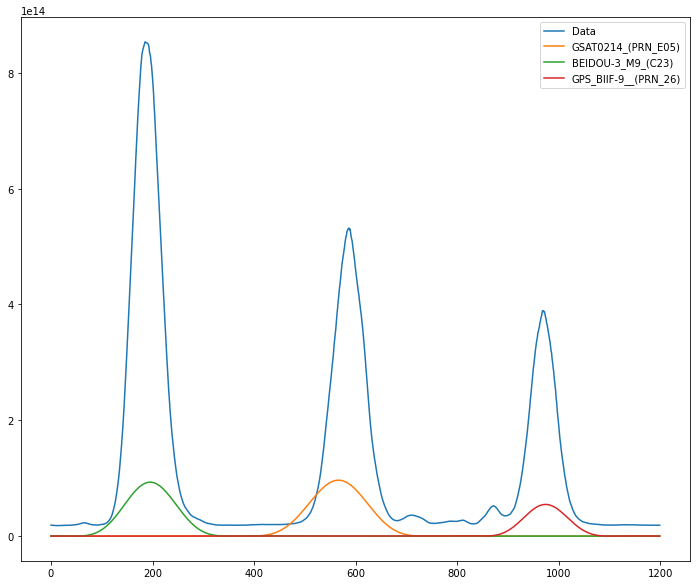

[185]


In [4]:
cut = [0,1200]
channel = 11

plt.figure(figsize=(12,10))
plt.plot(D[channel][cut[0]:cut[1]].real,label='Data')

tracks = {}
sats = {}
for n,s in zip(D.sat_id,D.sat):
    if "COS" not in n:
        #dx= np.exp(-np.cos(s['alt'])**2/(2*0.05**2))
        track = np.array([np.cos(s['alt'])*np.cos(s['az']),np.cos(s['alt'])*np.sin(s['az'])]).T
        tracks[n] = track
        dx = SingleFreqGeometry().point_source(channel,1,track).real
        sats[n] = dx
        if max(dx[cut[0]:cut[1]])>0.2:
            plt.plot(dx[cut[0]:cut[1]]*1e14,label=n)
        
plt.legend()
plt.show()
print(np.arange(cut[0],cut[1])[D[channel][cut[0]:cut[1]].real==max(D[channel][cut[0]:cut[1]].real)])

In [5]:
def gauss(params):
    x = np.arange(cut[0],cut[1])
    return np.exp(-(params[0]*(x-params[1]))**2+params[2])+params[3]

def gaussFit(params):
    fit = gauss(params)
    return D[ch][cut[0]:cut[1]].real-fit

[2.63327791e-02 1.88317927e+02 3.43726903e+01 2.02412948e+13]


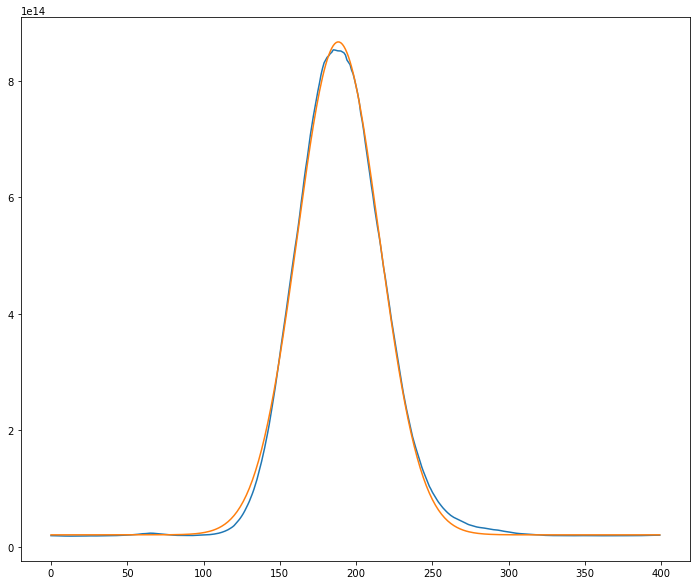

[2.38826072e-02 5.86477657e+02 3.38381282e+01 2.39355988e+13]


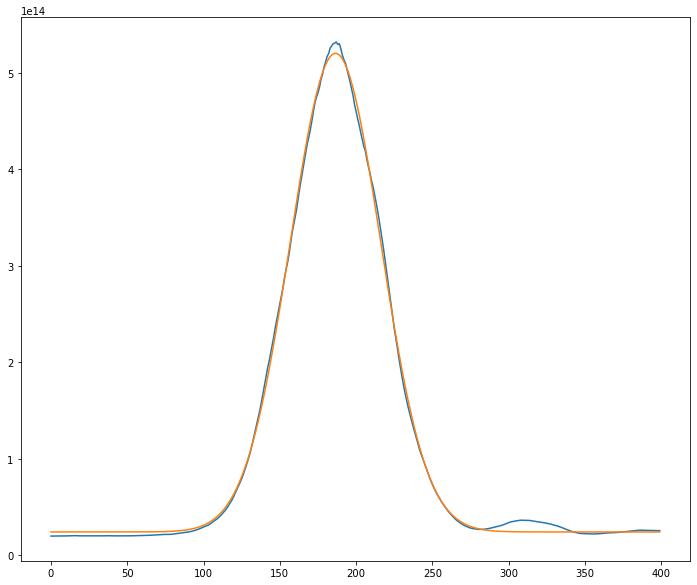

[2.88365112e-02 9.69616945e+02 3.35167886e+01 2.47156994e+13]


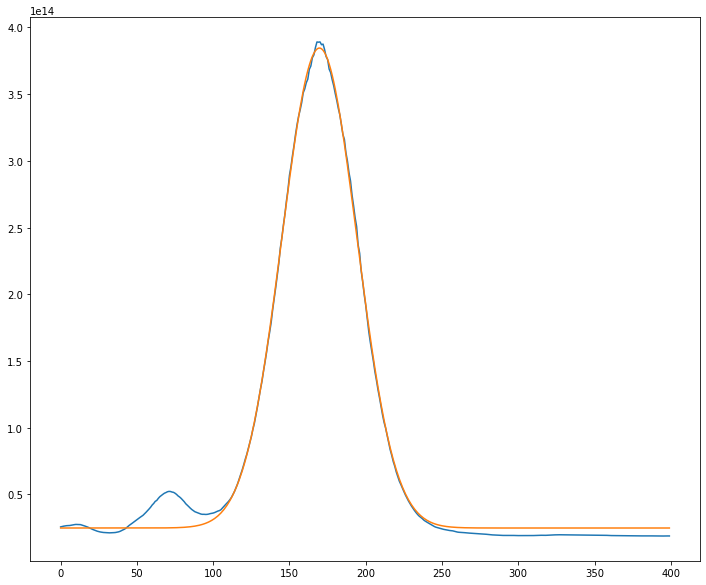

[3.17802719e-02 2.36145393e+03 3.14614440e+01 2.18586073e+13]


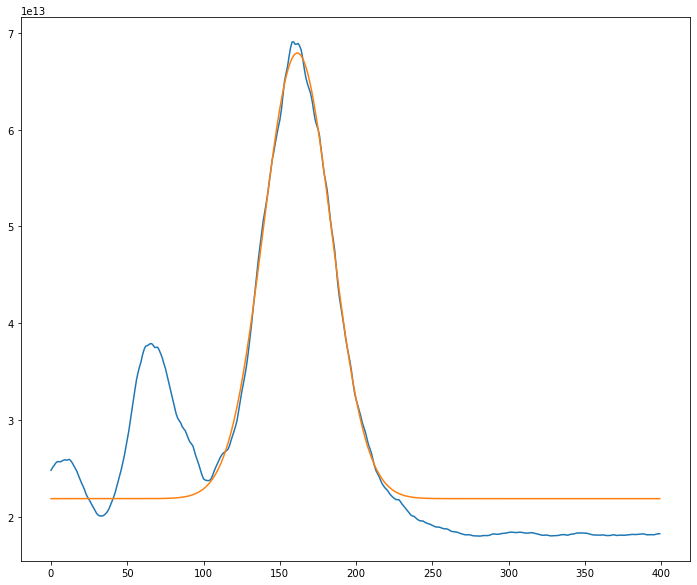

In [6]:
cuts = [[0,400],[400,800],[800,1200],[2200,2600]]
ch = 11

alpha = []
maxima = {}
vel = {}

for cut in cuts:
    fit = least_squares(gaussFit,[0.05,(cut[0]+cut[1])/2,35,3e13],bounds = ([0,cut[0],20,0],[1,cut[1],40,1e14]))
    params = fit.x
    print(params)
    center = (int(params[1].round()))
    satmax = ''
    a = 0
    for n in sats.keys():
        if sats[n][center] >= a:
            satmax = n
            a = sats[n][center]
    alpha.append(params[0])
    maxima[satmax] = [center]
    vel[satmax] = (tracks[satmax][center+1]-tracks[satmax][center-1])/2

    plt.figure(figsize=(12,10))
    plt.plot(D[ch][cut[0]:cut[1]].real)
    plt.plot(gauss(params))
    plt.show()
    
alpha = np.array(alpha)

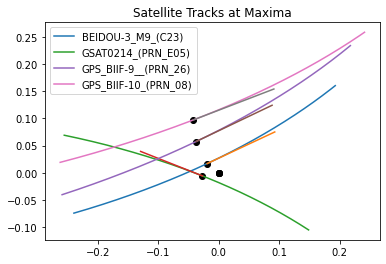

In [7]:
for i,n in enumerate(maxima.keys()):
    plt.plot(tracks[n][cuts[i][0]:cuts[i][1],0],tracks[n][cuts[i][0]:cuts[i][1],1],label=n)
    for j,m in enumerate(maxima[n]):
        plt.scatter(tracks[n][m,0],tracks[n][m,1],color='black')
        plt.plot([tracks[n][m,0],tracks[n][m,0]+vel[n][0]*100],[tracks[n][m,1],tracks[n][m,1]+vel[n][1]*100])
    plt.scatter(0,0,color='black')
plt.title("Satellite Tracks at Maxima")
plt.legend()
plt.show()

['A_GPS_BIII-4__(PRN_14)', 'A1_GPS_BIII-4__(PRN_14)', 'A2_GPS_BIII-4__(PRN_14)', 'A3_GPS_BIII-4__(PRN_14)', 'A4_GPS_BIII-4__(PRN_14)', 'A5_GPS_BIII-4__(PRN_14)', 'A6_GPS_BIII-4__(PRN_14)', 'A7_GPS_BIII-4__(PRN_14)', 'A8_GPS_BIII-4__(PRN_14)', 'A_GSAT0214_(PRN_E05)', 'A1_GSAT0214_(PRN_E05)', 'A2_GSAT0214_(PRN_E05)', 'A3_GSAT0214_(PRN_E05)', 'A4_GSAT0214_(PRN_E05)', 'A5_GSAT0214_(PRN_E05)', 'A6_GSAT0214_(PRN_E05)', 'A7_GSAT0214_(PRN_E05)', 'A8_GSAT0214_(PRN_E05)', 'A_BEIDOU-3_M21', 'A1_BEIDOU-3_M21', 'A2_BEIDOU-3_M21', 'A3_BEIDOU-3_M21', 'A4_BEIDOU-3_M21', 'A5_BEIDOU-3_M21', 'A6_BEIDOU-3_M21', 'A7_BEIDOU-3_M21', 'A8_BEIDOU-3_M21', 'A_BEIDOU-3_M9_(C23)', 'A1_BEIDOU-3_M9_(C23)', 'A2_BEIDOU-3_M9_(C23)', 'A3_BEIDOU-3_M9_(C23)', 'A4_BEIDOU-3_M9_(C23)', 'A5_BEIDOU-3_M9_(C23)', 'A6_BEIDOU-3_M9_(C23)', 'A7_BEIDOU-3_M9_(C23)', 'A8_BEIDOU-3_M9_(C23)', 'A_GPS_BIIF-11_(PRN_10)', 'A1_GPS_BIIF-11_(PRN_10)', 'A2_GPS_BIIF-11_(PRN_10)', 'A3_GPS_BIIF-11_(PRN_10)', 'A4_GPS_BIIF-11_(PRN_10)', 'A5_GPS_BIIF-1

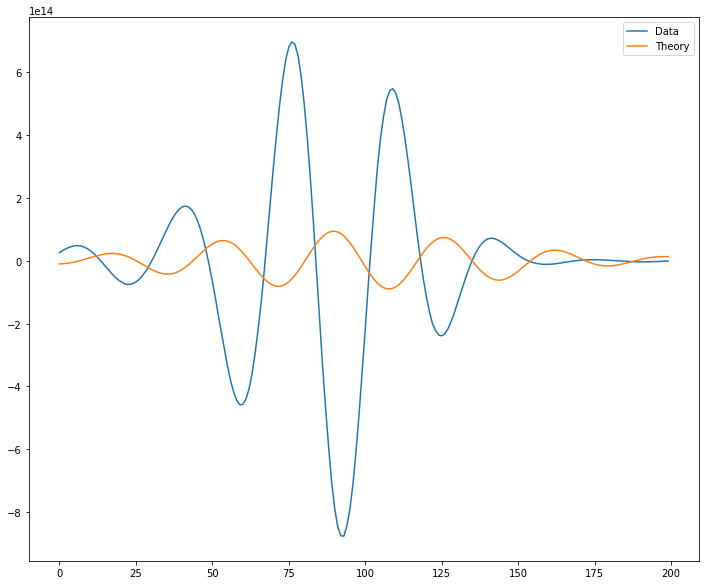

In [8]:
cut = [100,300]

plt.figure(figsize=(12,10))
plt.plot(D[23][cut[0]:cut[1]].real,label='Data')

theory = TheoryPredictor(D)
print(theory.allParameters())
plt.plot(theory.output(23).real[cut[0]:cut[1]]*1e14,label='Theory')

plt.legend()
plt.show()

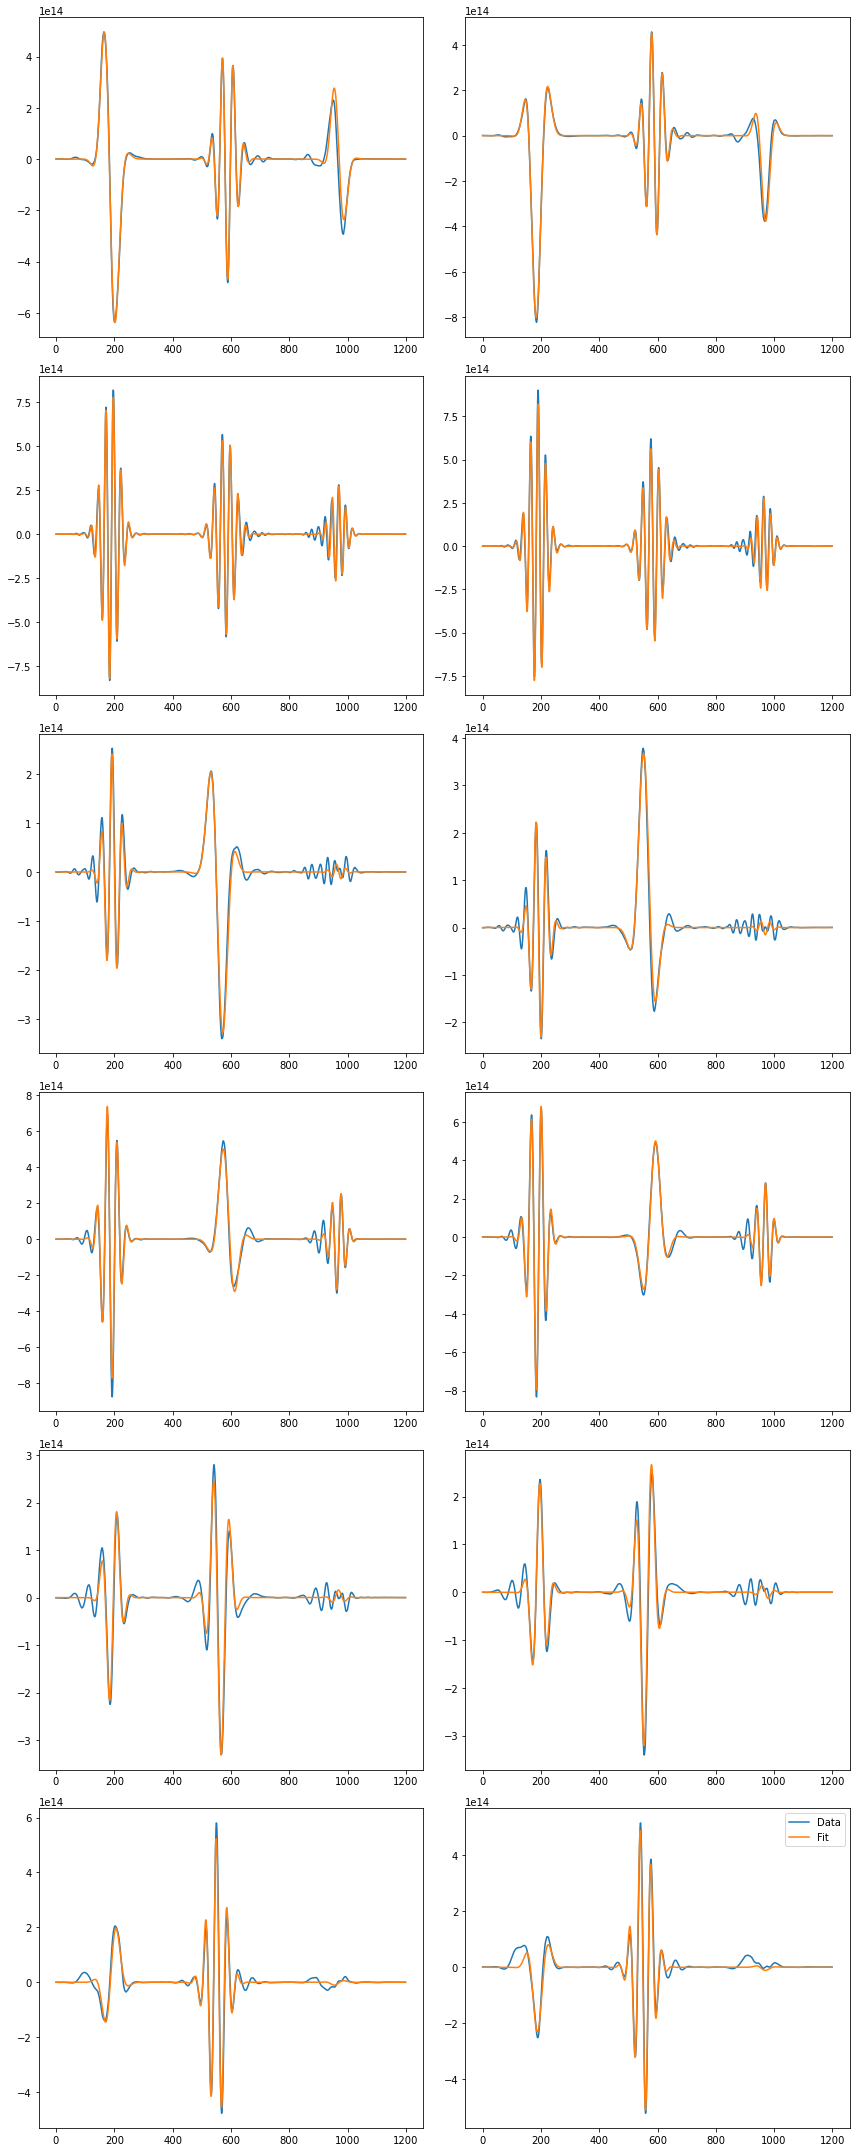

In [57]:
cut = [0,1200]
#channels = []
channels = [12,13,14,23,24,34]

theory = TheoryPredictor(D, satAmp=0)
theory.setParameters({'A1_BEIDOU-3_M9_(C23)':2.90343274e+07,
                      'A1_GSAT0214_(PRN_E05)':2.49536311e+07,
                      'A1_GPS_BIIF-9__(PRN_26)':2.88461511e+07,
                      'D1_beam_center_x':-1.90871184e-02,
                      'D1_beam_center_y':1.65122615e-02,
                      'D1_beam_smooth_x':5.05196347e-02,
                      'D1_beam_smooth_y':5.42165243e-02,
                      'CH11_offset':2.21507414e+13,
                      'A2_BEIDOU-3_M9_(C23)':2.80114112e+07,
                      'A2_GSAT0214_(PRN_E05)':2.38645275e+07,
                      'A2_GPS_BIIF-9__(PRN_26)':3.10590316e+07,
                      'D2_beam_center_x':-2.10388157e-02,
                      'D2_beam_center_y':1.65383259e-02,
                      'D2_beam_smooth_x':4.49615096e-02,
                      'D2_beam_smooth_y':5.07914419e-02,
                      'CH22_offset':2.27059365e+13,
                      'A3_BEIDOU-3_M9_(C23)':3.06971004e+07,
                      'A3_GSAT0214_(PRN_E05)':2.65858358e+07,
                      'A3_GPS_BIIF-9__(PRN_26)':3.33572275e+07,
                      'D3_beam_center_x':-1.22411279e-02,
                      'D3_beam_center_y':-8.57652626e-04,
                      'D3_beam_smooth_x':5.58290830e-02,
                      'D3_beam_smooth_y':5.58520638e-02,
                      'CH33_offset':3.44260253e+13,
                      'A4_BEIDOU-3_M9_(C23)':2.87770413e+07,
                      'A4_GSAT0214_(PRN_E05)':2.78199049e+07,
                      'A4_GPS_BIIF-9__(PRN_26)':3.85992804e+07,
                      'D4_beam_center_x':3.56587146e-02,
                      'D4_beam_center_y':-1.93843296e-02,
                      'D4_beam_smooth_x':5.27998514e-02,
                      'D4_beam_smooth_y':3.37224349e-02,
                      'CH44_offset':2.57524150e+13,
                      'D_all_dist':-4.52054926e+00,
                      #'D1_pos_x':0,
                      #'D1_pos_y':0,
                      'D1_beam_sigma_x':6.79574771e-02,
                      'D1_beam_sigma_y':6.88009622e-02,
                      #'D1_phi':-5.2206034,
                      #'D2_pos_x':-4.52,
                      #'D2_pos_y':1.51642923e-03,
                      'D2_beam_sigma_x':6.28465255e-02,
                      'D2_beam_sigma_y':6.11850725e-02,
                      'D2_phi':-2.49089886e-01,
                      'D3_pos_x':-8.78400537e+00,
                      'D3_pos_y':-4.18190819e+00,
                      'D3_beam_sigma_x':9.11159079e-02,
                      'D3_beam_sigma_y':4.83194922e-02,
                      'D3_phi':2.35269391e+00,
                      'D4_pos_x':-4.16252250e+00,
                      'D4_pos_y':-8.50162841e+00,
                      'D4_phi':-2.76945642e-01,
                      'D4_beam_sigma_x':5.55926832e-02,
                      'D4_beam_sigma_y':9.30582348e-02,
                     })
#print(theory.allParameters())

names = [] #names of independent variables

def fitFunc(params):
    p = {}
    for i,n in enumerate(names):
        p[n] = params[i]
    theory.setParameters(p)
    out = []
    for ch in channels:
        prediction = theory.output(ch)[cut[0]:cut[1]]
        data = D[ch][cut[0]:cut[1]]
        out.append(data.real-prediction.real)
        out.append(data.imag-prediction.imag)
    out = np.array(out).flatten()
    return out/1e14

def showFunc(params):
    p = {}
    for i,n in enumerate(names):
        p[n] = params[i]
    theory.setParameters(p)
    Dout = []
    Pout = []
    for ch in channels:
        prediction = theory.output(ch)[cut[0]:cut[1]]
        data = D[ch][cut[0]:cut[1]]
        Dout.append([data.real,data.imag])
        Pout.append([prediction.real, prediction.imag])
    Dout = np.array(Dout)
    Pout = np.array(Pout)
    return Dout,Pout

dat, fit = showFunc([])

fig = plt.figure(figsize = (12,5*len(channels)))
axes = fig.subplots(nrows= len(dat), ncols=2)
if len(dat)==1:
    axes = np.array([axes])

for i,ch in enumerate(channels):
    axes[i][0].plot(dat[i,0],label='Data')
    axes[i][0].plot(fit[i,0],label='Fit')
    
    axes[i][1].plot(dat[i,1],label='Data')
    axes[i][1].plot(fit[i,1],label='Fit')

plt.legend()

plt.tight_layout()
plt.show()

In [52]:
fit = least_squares(fitFunc,[-4.5,4.5,-0.75],
                    bounds=([-6,2,-4],[-2,6,4]))
params = fit.x
print(params)

[-4.5         4.5        -0.74530559]


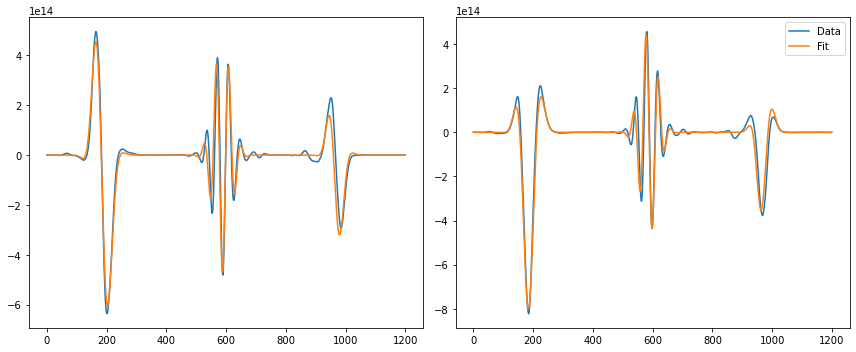

In [53]:
dat,fit = showFunc(params)

fig = plt.figure(figsize = (12,5*len(channels)))
axes = fig.subplots(nrows= len(dat), ncols=2)
if len(dat)==1:
    axes = np.array([axes])

for i,ch in enumerate(channels):
    axes[i][0].plot(dat[i,0],label='Data')
    axes[i][0].plot(fit[i,0],label='Fit')
    
    axes[i][1].plot(dat[i,1],label='Data')
    axes[i][1].plot(fit[i,1],label='Fit')

plt.legend()

plt.tight_layout()
plt.show()

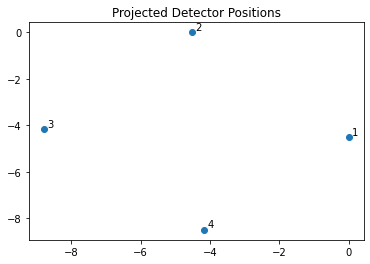

In [58]:
p = theory.readParameters()
xs = []
ys = []
for i in range(4):
    xs.append(p['D{}_pos_x'.format(i+1)])
    ys.append(p['D{}_pos_y'.format(i+1)])
plt.title('Projected Detector Positions')
plt.scatter(xs,ys)
for i in range(4):
    plt.text(xs[i]+0.1,ys[i]+0.1,str(i+1))
plt.show()